# GAN with 1D data

In [39]:
!pip show tensorflow

Name: tensorflow
Version: 2.18.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: C:\Users\DoHyeonjik\anaconda3\Lib\site-packages
Requires: tensorflow-intel
Required-by: 


In [21]:
# 실제 데이터를 생성하는 함수
import numpy as np

def generate_real_samples(n):
    x1 = np.random.rand(n) - 0.5 # -0.5와 0.5 사이의 n개의 랜덤한 값으로 배열 생성
    x2 = x1**3                   # 배열 세제곱
    x1 = x1.reshape(n,1)         # 2차원 배열로 reshape
    x2 = x2.reshape(n,1)         # 2차원 배열로 reshape
    x = np.hstack((x1,x2))       # x1과 x2 병합
    y = np.ones((n,1)) *0.9          # 레이블 생성 : 판별기의 과도한 확신을 막기위해 정답 레이블을 1->0.9로 수정(Label smoothing)
    return x, y          

In [22]:
from tensorflow import keras
from keras.layers import Dense, LeakyReLU
from keras.models import Sequential

# 팡별기 모델 생성 함수
def define_discriminator(inputs= 2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer = 'he_uniform', input_dim = inputs))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(15, activation='relu', kernel_initializer = 'he_uniform'))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(5, activation='relu', kernel_initializer = 'he_uniform'))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(1, activation='sigmoid')) # 판별기의 마지막은 0~1사이의 값
    model.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model


In [23]:
# 판별기 모델 생성
discriminator_model = define_discriminator()
discriminator_model.summary()

C:\Users\DoHyeonjik\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\DoHyeonjik\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_7 (Dense)                      │ (None, 25)                  │              75 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_5 (LeakyReLU)            │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 15)                  │             390 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_6 (LeakyReLU)            │ (None, 15)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_9 (Dense)                      │ (None, 5)                   │              80 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_7 (LeakyReLU)            │ (None, 5)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │               6 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 551 (2.15 KB)

 Trainable params: 551 (2.15 KB)

 Non-trainable params: 0 (0.00 B)

In [24]:
# 생성기 생성 함수
def define_generator(latent_dim, outputs=2):
    model = Sequential()
    model.add(Dense(25, activation='relu', kernel_initializer='he_uniform', input_dim = latent_dim))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(15, activation='relu', kernel_initializer='he_uniform'))
    model.add(LeakyReLU(alpha=0.01))
    model.add(Dense(outputs, activation='linear'))
    return model
    


In [25]:
# 생성기 모델 생성
latent_dim = 5 # 잠재벡터의 차원 설정
generator_model = define_generator(latent_dim)
generator_model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_11 (Dense)                     │ (None, 25)                  │             150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_8 (LeakyReLU)            │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 15)                  │             390 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_9 (LeakyReLU)            │ (None, 15)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 2)                   │              32 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 572 (2.23 KB)

 Trainable params: 572 (2.23 KB)

 Non-trainable params: 0 (0.00 B)

In [26]:
# 잠재 벡터 z 생성함수
def generate_latent_points(latent_dim, n):
    x_input = np.random.rand(latent_dim*n) #정규 분포에서 랜덤한 배열 생성
    x_input = x_input.reshape(n,latent_dim)  # reshape(잠재벡터 차원 : 5)
    return x_input

## GAN에서 latent_space는 직접 이미지를 입력받아서 학습되는 것이 아니라
## G와 D의 loss에 의해 학습과정에서 사용됨
## z의 분는 고정되어 있으며 변하지 않음
## 생성자가 실제 데이터의 분포를 모방하기 위해서 z와 실제 데이터간의 매핑을 학습

In [27]:
# 가짜 이미지 : 생성자의 출력값
def generate_fake_samples(generator, latent_dim, n):
    x_input = generate_latent_points(latent_dim, n) # 잠재벡터 생성 : 위의 함수 사용
    x = generator.predict(x_input) #생성자를 통해 나온 가짜 이미지
    y = np.zeros((n, 1)) # 가짜이미지 레이블의 값은 0
    return x, y

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step


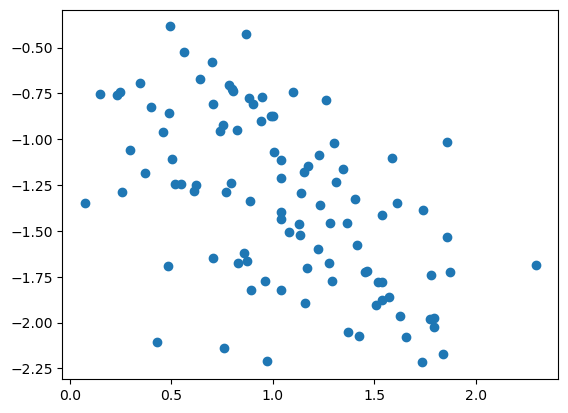

In [28]:
import matplotlib.pyplot as plt

x, y = generate_fake_samples(generator_model, latent_dim, 100)
plt.scatter(x[:, 0], x[:,1])
plt.show()

In [29]:
# GAN 모델 생성 함수
def define_gan(generator, discriminator):
    discriminator.trainable= False # GAN 모델은 위 프로그램에서 생성자 학습을 위한 것이므로, 판별기는 고정되어야 함
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    model.compile(optimizer='adam', loss='binary_crossentropy')
    return model
    

In [30]:
gan = define_gan(generator_model, discriminator_model)
gan.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_4 (Sequential)            │ (None, 2)                   │             572 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_3 (Sequential)            │ (None, 1)                   │             551 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,123 (4.39 KB)

 Trainable params: 572 (2.23 KB)

 Non-trainable params: 551 (2.15 KB)

## 훈련

In [35]:
# 모델 훈련 함수
def train_gan(g_model,d_model,gan_model,latent_dim, num_epochs= 100 ,num_eval = 10, batch_size = 128):
    half_batch = int(batch_size/2)
    for i in range(num_epochs): 
        d_model.trainable = True
        X_real, y_real = generate_real_samples(half_batch) #실제 데이터 생성 : 64개
        d_model.train_on_batch(X_real, y_real)             #판별기 훈련
        X_fake, y_fake = generate_fake_samples(g_model, latent_dim, half_batch) # 가짜 이미지 생성
        # d_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
        d_model.train_on_batch(X_fake, y_fake)             #판별기 훈련

        # gan_model.compile(optimizer='adam', loss='binary_crossentropy')
        x_gan = generate_latent_points(latent_dim, batch_size) # G(z)를 위한 z 생성
        y_gan = np.ones((batch_size, 1))      # z의 레이블 생성  
        gan_model.train_on_batch(x_gan, y_gan)                 # GAN 모델 훈련 = 생성기 훈련
        
        if (i+1) % num_eval == 0:
            summarize_performance(i + 1, g_model, d_model, latent_dim)

In [36]:
def summarize_performance(epoch, generator, discriminator, latent_dim, n = 64):
    x_real, y_real = generate_real_samples(n)      # 실제 데이터 생성
    _, acc_real = discriminator.evaluate(x_real, y_real, verbose = 1) # 모델 평가( _ : loss / acc : accuracy)
    x_fake, y_fake = generate_fake_samples(generator, latent_dim, n) # 가짜 데이터 생성
    _, acc_fake = discriminator.evaluate(x_fake, y_fake, verbose = 1) # 가짜 데이터에 대한 모델 평가
    print('Epoch: ' + str(epoch) + ' Real Acc.: ' + str(acc_real) + ' Fake Acc.: '+ str(acc_fake))
    plt.scatter(x_real[:,0], x_real[:,1], color = 'red')
    plt.scatter(x_fake[:,0], x_fake[:,1], color = 'blue')
    plt.show()

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0000e+00 - loss: 0.6831
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0000e+00 - loss: 6.0383
Epoch: 10 Real Acc.: 0.0 Fake Acc.: 0.0


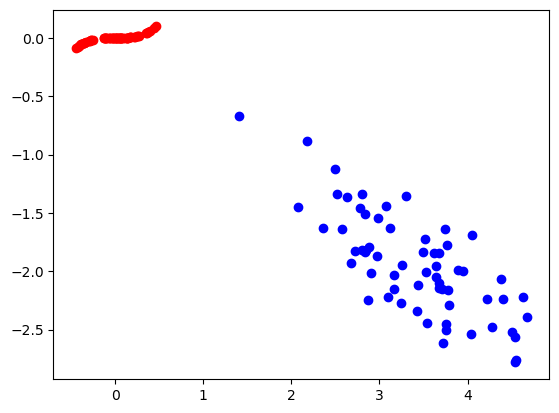

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0000e+00 - loss: 0.6456
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 3.9580
Epoch: 20 Real Acc.: 0.0 Fake Acc.: 0.0


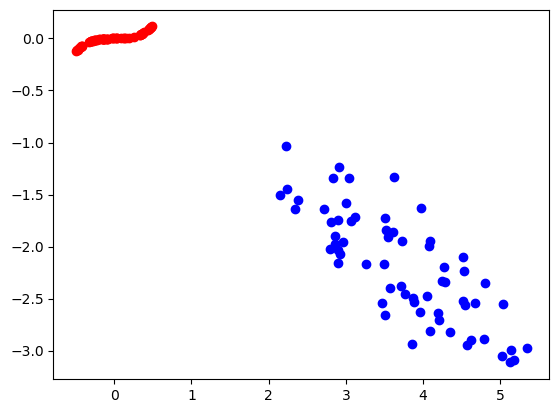

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0000e+00 - loss: 0.5966
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 1.5980
Epoch: 30 Real Acc.: 0.0 Fake Acc.: 0.0


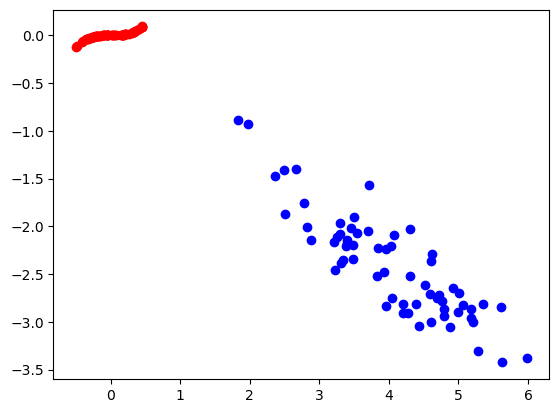

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.5521
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0000e+00 - loss: 0.7884
Epoch: 40 Real Acc.: 0.0 Fake Acc.: 0.0


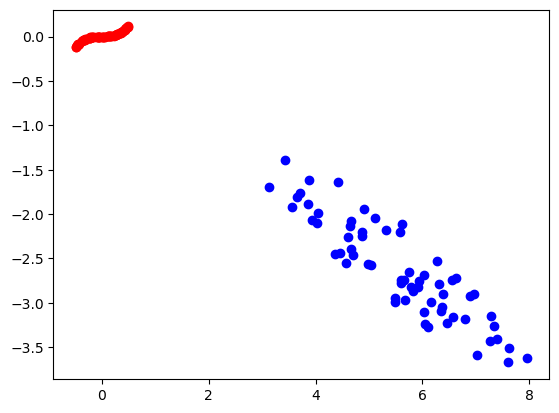

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0000e+00 - loss: 0.5457
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9271 - loss: 0.6815
Epoch: 50 Real Acc.: 0.0 Fake Acc.: 0.921875


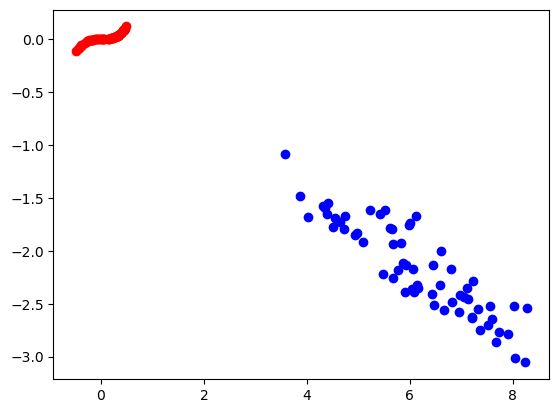

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 0.5284
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9583 - loss: 0.6775
Epoch: 60 Real Acc.: 0.0 Fake Acc.: 0.96875


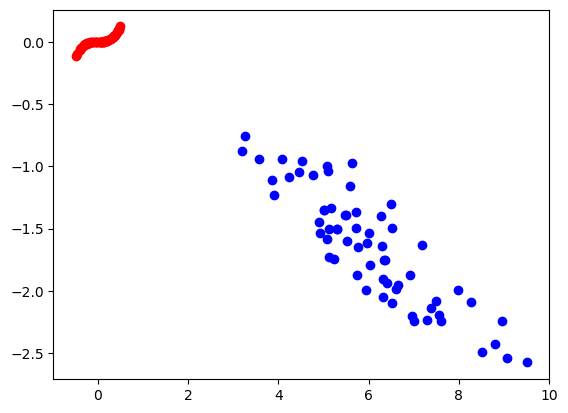

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/stepe
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0000e+00 - loss: 0.5091
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.9375 - loss: 0.6771
Epoch: 70 Real Acc.: 0.0 Fake Acc.: 0.9375


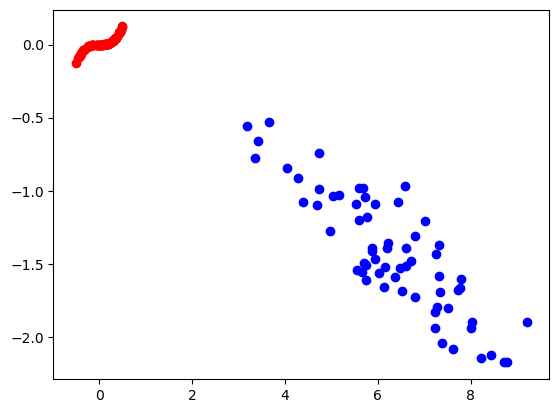

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.4605
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9688 - loss: 0.6729
Epoch: 80 Real Acc.: 0.0 Fake Acc.: 0.96875


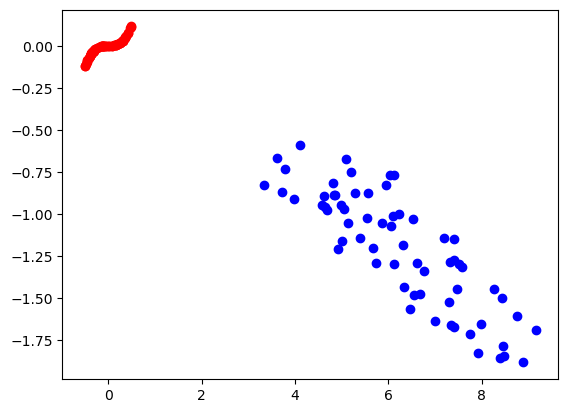

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0000e+00 - loss: 0.4597
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9688 - loss: 0.6712
Epoch: 90 Real Acc.: 0.0 Fake Acc.: 0.96875


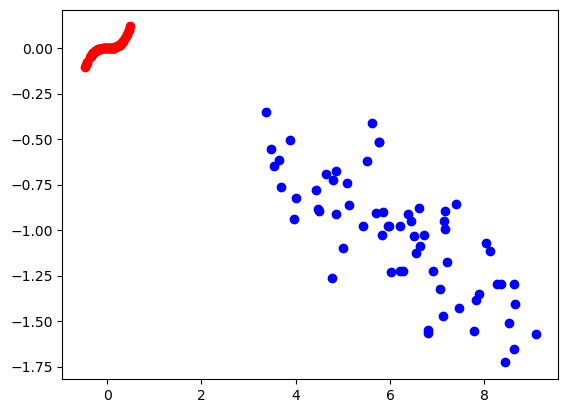

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/stepe
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0000e+00 - loss: 0.4413
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 1.0000 - loss: 0.6668
Epoch: 100 Real Acc.: 0.0 Fake Acc.: 1.0


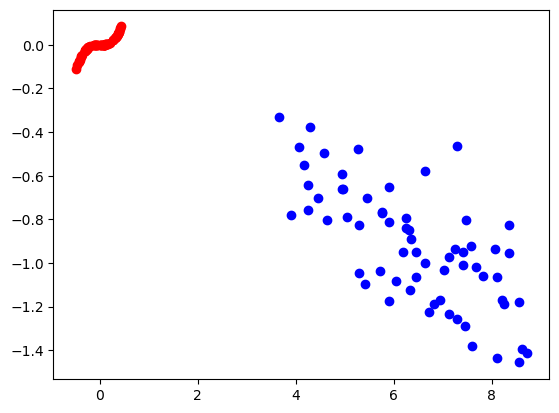

In [37]:
discriminator_model.compile(optimizer='adam', metrics=['accuracy'], loss='binary_crossentropy')
train_gan(generator_model, discriminator_model, gan, latent_dim)

In [21]:
####### 결과 #########33
# 생성기가 생성하는 이미지의 분포가 전혀 편향되어 있지 않고 실제 데이터의 분포를 따라가는 경향이라서
# mode collapse의 가능성은 낮다고 생각함
# 정확도가 낮게 나오는 이유는 판별기의 학습능력 부족이라고 판단하여 lr을 올려서 다시 학습 진행
from keras.optimizers import Adam

adam = Adam(learning_rate = 0.01, beta_1=0.5)  
discriminator_model.compile(optimizer= adam, loss='binary_crossentropy', metrics=['accuracy'])
                            

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.0000e+00 - loss: 0.6691
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9479 - loss: 0.5672
Epoch: 10 Real Acc.: 0.0 Fake Acc.: 0.953125


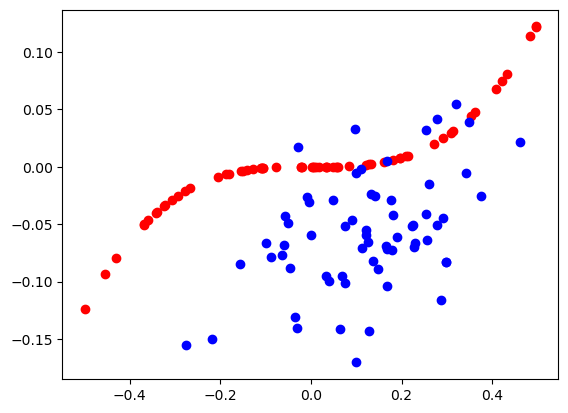

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 0.7080
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.9688 - loss: 0.4383
Epoch: 20 Real Acc.: 0.0 Fake Acc.: 0.953125


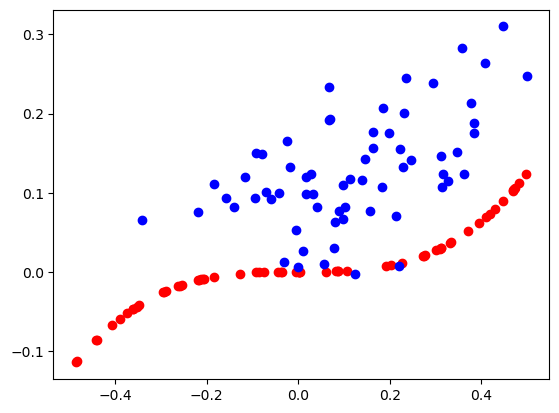

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/stepe
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.0000e+00 - loss: 0.6588
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.8333 - loss: 0.5974
Epoch: 30 Real Acc.: 0.0 Fake Acc.: 0.828125


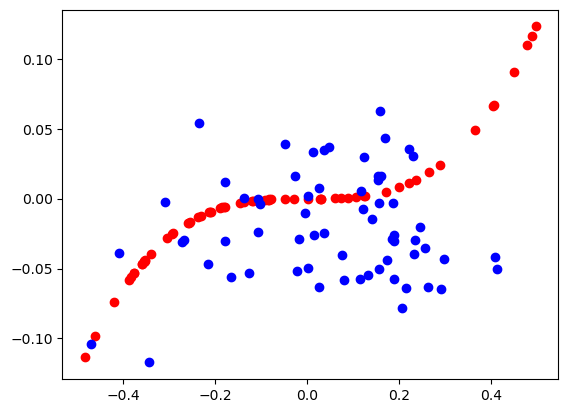

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 0.7284
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 1.0000 - loss: 0.3913
Epoch: 40 Real Acc.: 0.0 Fake Acc.: 1.0


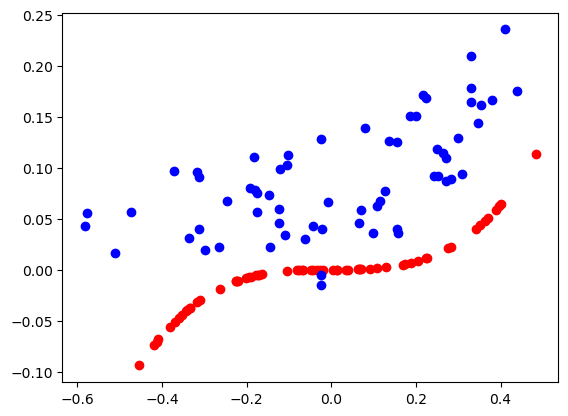

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 0.8686
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.3348
Epoch: 50 Real Acc.: 0.0 Fake Acc.: 1.0


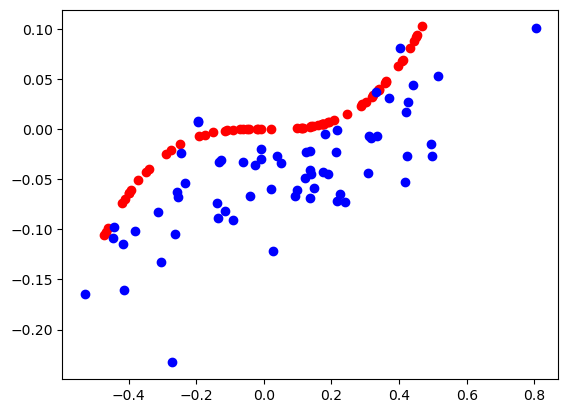

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0000e+00 - loss: 0.7576
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.9792 - loss: 0.3684
Epoch: 60 Real Acc.: 0.0 Fake Acc.: 0.96875


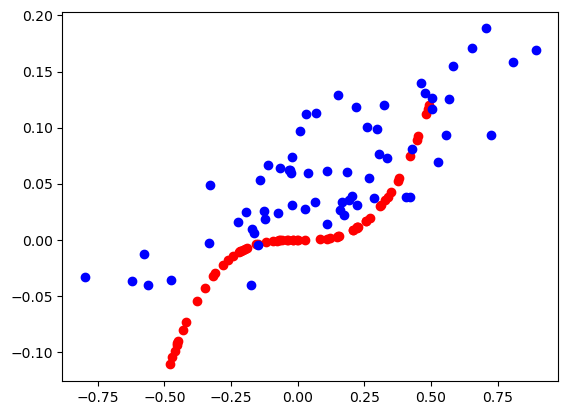

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.0000e+00 - loss: 0.7956  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.7188 - loss: 0.4933
Epoch: 70 Real Acc.: 0.0 Fake Acc.: 0.6875


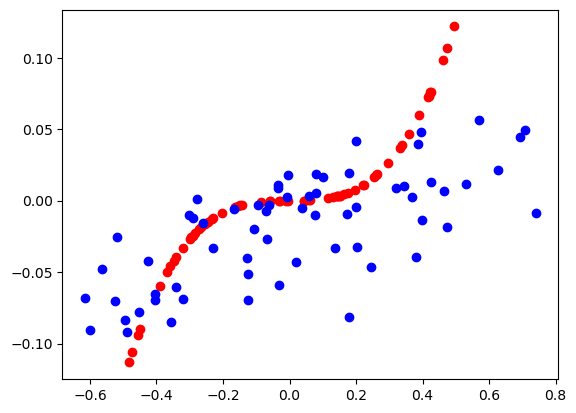

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.0000e+00 - loss: 0.7234
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7604 - loss: 0.5140
Epoch: 80 Real Acc.: 0.0 Fake Acc.: 0.75


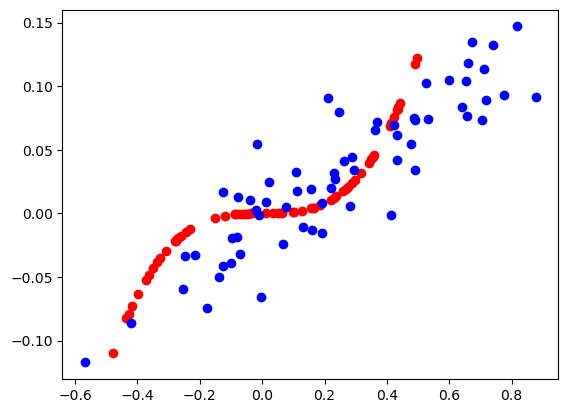

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.0000e+00 - loss: 0.7505
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.9479 - loss: 0.3923
Epoch: 90 Real Acc.: 0.0 Fake Acc.: 0.9375


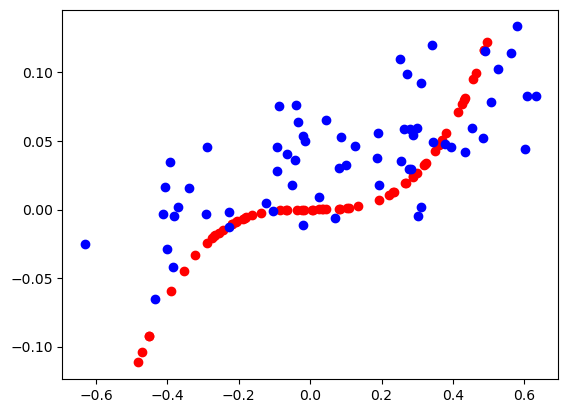

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.0000e+00 - loss: 0.7425 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step - accuracy: 0.7604 - loss: 0.4553 
Epoch: 100 Real Acc.: 0.0 Fake Acc.: 0.796875


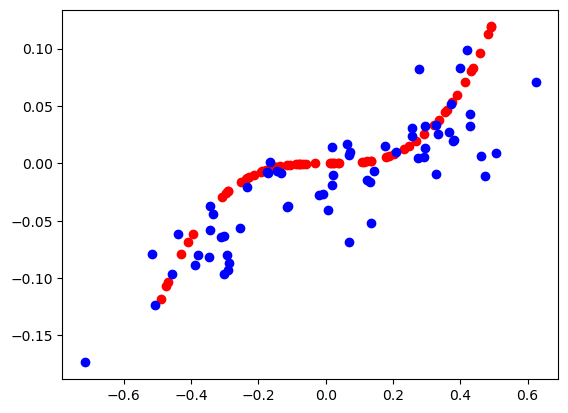

In [22]:
train_gan(generator_model, discriminator_model, gan, latent_dim)

In [33]:
##### 판별기 모델 일부 수정(dropout 추가 및 Dense 수정)
import tensorflow as tf
from tensorflow.keras.layers import Dropout

def define_discriminator(inputs= 2):
    model = Sequential()
    model.add(Dense(50, activation='relu', kernel_initializer = 'he_uniform', input_dim = inputs))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(25, activation='relu', kernel_initializer = 'he_uniform'))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dropout(0.4))
    model.add(Dense(15, activation='relu', kernel_initializer = 'he_uniform'))
    model.add(LeakyReLU(alpha = 0.01))
    model.add(Dense(1, activation='sigmoid')) # 판별기의 마지막은 0~1사이의 값
    return model


d_model = define_discriminator()
d_model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer='adam')
d_model.summary()

C:\Users\DoHyeonjik\anaconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\DoHyeonjik\anaconda3\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_10 (Dense)                     │ (None, 50)                  │             150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_13 (LeakyReLU)           │ (None, 50)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 25)                  │           1,275 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_14 (LeakyReLU)           │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 25)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 15)                  │             390 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_15 (LeakyReLU)           │ (None, 15)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 1)                   │              16 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,831 (7.15 KB)

 Trainable params: 1,831 (7.15 KB)

 Non-trainable params: 0 (0.00 B)

In [35]:
gan2 = define_gan(generator_model, d_model)
gan2.summary()

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ sequential_1 (Sequential)            │ (None, 2)                   │             572 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential_7 (Sequential)            │ (None, 1)                   │           1,831 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,403 (9.39 KB)

 Trainable params: 572 (2.23 KB)

 Non-trainable params: 1,831 (7.15 KB)

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 0.6804
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 0.0521 - loss: 0.8020
Epoch: 10 Real Acc.: 0.0 Fake Acc.: 0.046875


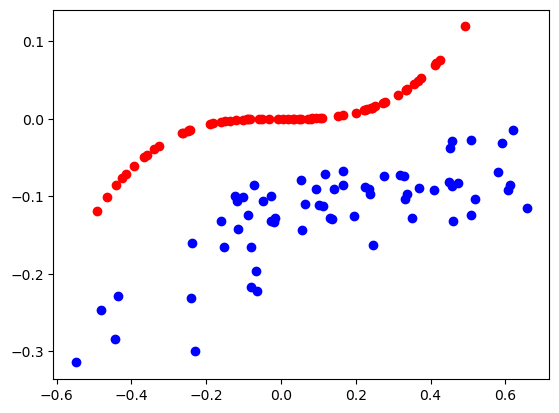

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 0.6670
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step - accuracy: 1.0000 - loss: 0.5719 
Epoch: 20 Real Acc.: 0.0 Fake Acc.: 1.0


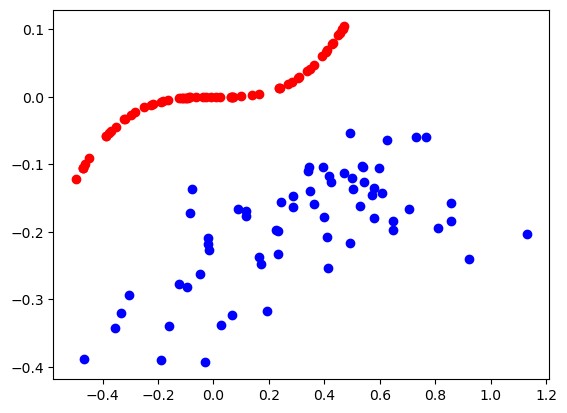

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.0000e+00 - loss: 0.6193
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 1.0000 - loss: 0.5210
Epoch: 30 Real Acc.: 0.0 Fake Acc.: 1.0


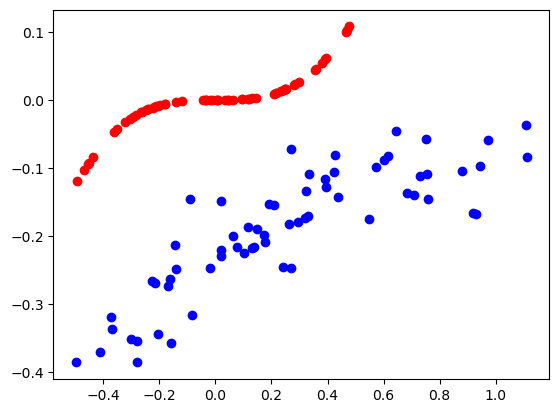

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.0000e+00 - loss: 0.6048
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7604 - loss: 0.6025
Epoch: 40 Real Acc.: 0.0 Fake Acc.: 0.75


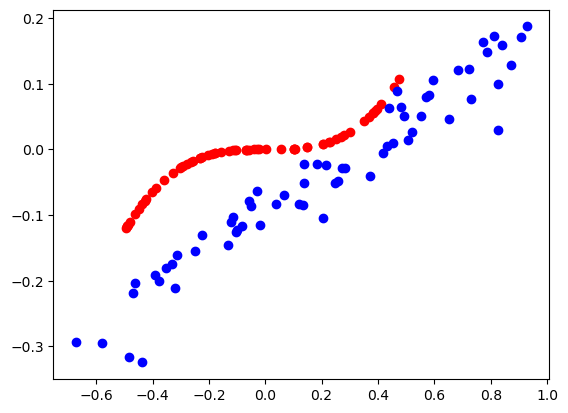

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 0s/step  
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.0000e+00 - loss: 0.7573
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - accuracy: 0.2083 - loss: 0.8380
Epoch: 50 Real Acc.: 0.0 Fake Acc.: 0.203125


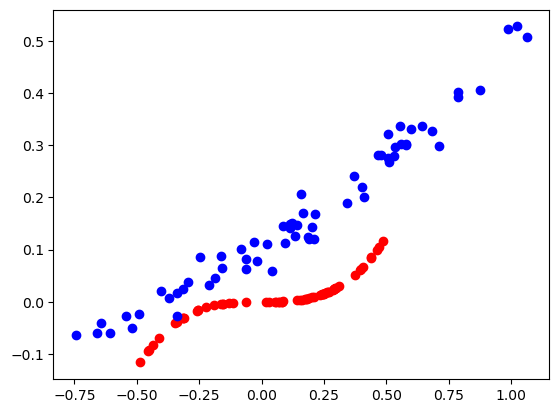

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 


KeyboardInterrupt: 

In [37]:
adam = Adam(learning_rate = 0.01, beta_1=0.5)  

d_model.compile(loss='binary_crossentropy', metrics=['accuracy'],optimizer='adam')
train_gan(generator_model, d_model, gan2, latent_dim)